In [1]:
# -----------------------------------------------------------------
# 单元 1: 导入所有必需的库 (Import Libraries)
# -----------------------------------------------------------------
import pandas as pd                 # 用于数据处理和读取CSV文件 (就像Python里的Excel)
import numpy as np                  # 用于科学计算，尤其是数组操作
import matplotlib.pyplot as plt     # 用于创建基础的图表
import seaborn as sns               # 用于创建更漂亮、更高级的统计图表 (基于matplotlib)

# 从 scikit-learn (sklearn) 库中导入我们的工具
from sklearn.model_selection import train_test_split  # 用于将数据分为训练集和测试集
from sklearn.preprocessing import StandardScaler      # 用于数据标准化 (特征缩放)

# 导入回归模型
from sklearn.linear_model import LinearRegression     # 线性回归 (基础模型)
from sklearn.ensemble import RandomForestRegressor    # 随机森林 (高级模型)

# 导入评估指标
from sklearn.metrics import mean_squared_error, r2_score # 用于评估回归模型的表现

# 设置图表样式 (让图表更好看)
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

print("所有库导入成功！")

所有库导入成功！


In [3]:
# -----------------------------------------------------------------
# 单元 2: 加载我们在Weka中处理好的数据 (Load Data)
# -----------------------------------------------------------------

# 加载用于预测、分类和聚类的数据
# 这是我们在Weka中添加了 'Energy_Efficiency' (并离散化) 后的数据
try:
    df = pd.read_csv('dataset_preprocessed.csv')
except FileNotFoundError:
    print("错误：未找到 'dataset_preprocessed.csv' 文件。")
    print("请确保该文件与您的Notebook在同一目录下。")

# 加载用于关联分析的数据
# 这是我们在Weka中对多个特征进行了离散化后的数据
try:
    df_assoc = pd.read_csv('dataset_for_association.csv')
except FileNotFoundError:
    print("错误：未找到 'dataset_for_association.csv' 文件。")
    print("请确保该文件与您的Notebook在同一目录下。")


# 打印数据信息，确保Weka的处理被正确读取
if 'df' in locals():
    print("--- 'dataset_preprocessed.csv' (主数据) 加载信息 ---")
    print(df.info())
    print("\n--- 'dataset_preprocessed.csv' (主数据) 预览 (前5行) ---")
    print(df.head())

--- 'dataset_preprocessed.csv' (主数据) 加载信息 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Server_Workload                 3498 non-null   float64
 1   Inlet_Temperature               3498 non-null   float64
 2   Outlet_Temperature              3498 non-null   float64
 3   Ambient_Temperature             3498 non-null   float64
 4   Cooling_Unit_Power_Consumption  3498 non-null   float64
 5   Chiller_Usage                   3498 non-null   float64
 6   AHU_Usage                       3498 non-null   float64
 7   Total_Energy_Cost               3498 non-null   float64
 8   Temperature_Deviation           3498 non-null   float64
 9   Cooling_Strategy_Action         3498 non-null   object 
 10  Output                          3498 non-null   int64  
 11  Energy_Efficiency               3498 non-null   o

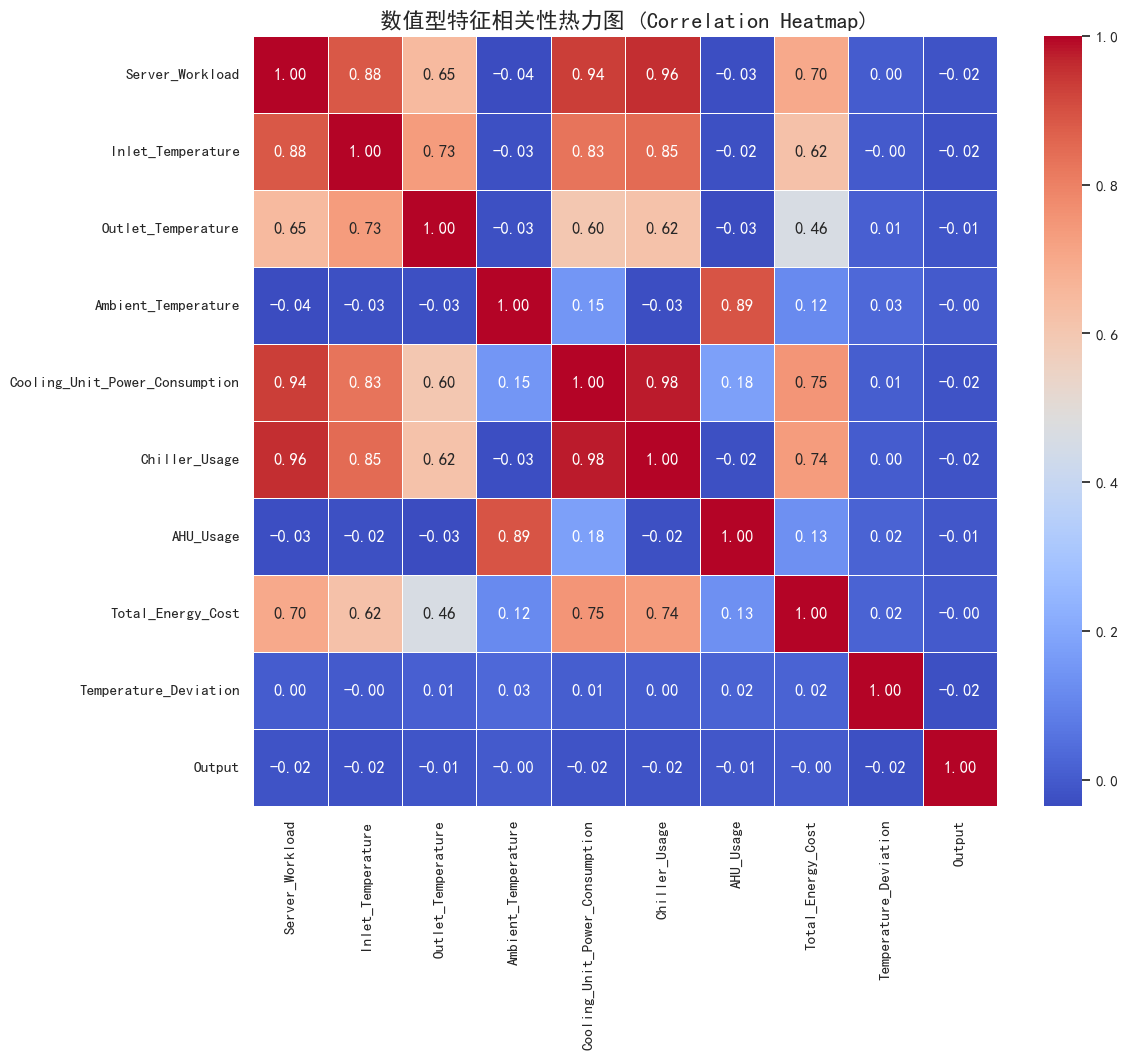

In [4]:
# -----------------------------------------------------------------
# 单元 3: 绘制数值型特征的相关性热力图 (EDA - Heatmap)
# -----------------------------------------------------------------

# 1. 选择所有数值型的列进行相关性计算
# (相关性矩阵只能在数字之间计算)
numeric_features = df.select_dtypes(include=np.number)

# 2. 计算相关性矩阵
corr_matrix = numeric_features.corr()

# 3. 绘制热力图
plt.figure(figsize=(12, 10)) # 设置图表大小
sns.heatmap(
    corr_matrix,          # 要绘制的数据
    annot=True,             # 在格子上显示数字
    cmap='coolwarm',        # 使用 '冷-暖' 色调 (红=正相关, 蓝=负相关)
    fmt='.2f',              # 数字格式化 (保留两位小数)
    linewidths=0.5          # 格子之间的线条宽度
)
plt.title('数值型特征相关性热力图 (Correlation Heatmap)', fontsize=16)
plt.show()

In [5]:
# -----------------------------------------------------------------
# 单元 4: 定义特征 (X) 和 目标 (y)，并划分数据集
# -----------------------------------------------------------------

# 1. 定义目标 (y)
# 我们的目标是两个列
targets_y = df[['Cooling_Unit_Power_Consumption', 'Temperature_Deviation']]

# 2. 定义特征 (X)
# 特征是所有用于预测的输入列
# 我们必须移除目标列本身，以及我们在Weka中创建的分类标签
features_X = df.drop(columns=[
    'Cooling_Unit_Power_Consumption',  # 这是目标
    'Temperature_Deviation',           # 这也是目标
    'Energy_Efficiency',               # 这是分类任务的目标
    'Cooling_Strategy_Action',         # 这是一个分类标签
    'Output'                           # 这是一个分类标签
])

# 3. 划分训练集和测试集
# 我们将数据分为 "作业" (训练集) 和 "考试" (测试集)
# 70% 的数据用于训练，30% 的数据用于测试
X_train, X_test, y_train, y_test = train_test_split(
    features_X,    # 特征
    targets_y,     # 目标
    test_size=0.3, # 测试集占 30%
    random_state=42 # 随机种子，确保每次划分结果都一样，便于复现
)

# 打印划分后的数据形状
print("--- 数据集划分结果 ---")
print(f"X_train (训练特征) 形状: {X_train.shape}")
print(f"X_test (测试特征) 形状: {X_test.shape}")
print(f"y_train (训练目标) 形状: {y_train.shape}")
print(f"y_test (测试目标) 形状: {y_test.shape}")

--- 数据集划分结果 ---
X_train (训练特征) 形状: (2448, 7)
X_test (测试特征) 形状: (1050, 7)
y_train (训练目标) 形状: (2448, 2)
y_test (测试目标) 形状: (1050, 2)


In [6]:
# -----------------------------------------------------------------
# 单元 5: 数据标准化 (Standardization)
# -----------------------------------------------------------------

# 1. 创建一个标准化 "缩放器" (Scaler)
scaler = StandardScaler()

# 2. 在训练集 (X_train) 上 "学习" 均值和标准差
#    并 "转换" X_train
#    注意：使用 .fit_transform()
X_train_scaled = scaler.fit_transform(X_train)

# 3. 在测试集 (X_test) 上 "应用" 相同的变换
#    注意：只使用 .transform()，不再 "学习"
X_test_scaled = scaler.transform(X_test)

print("数据标准化完成。")
print(f"标准化前 (X_train) 的均值 (示例): {X_train['Server_Workload'].mean():.2f}")
print(f"标准化后 (X_train_scaled) 的均值 (示例): {X_train_scaled[:, 0].mean():.2f}") # 接近0

数据标准化完成。
标准化前 (X_train) 的均值 (示例): 65.26
标准化后 (X_train_scaled) 的均值 (示例): -0.00


In [7]:
# -----------------------------------------------------------------
# 单元 6: 训练并评估 "模型 1: 线性回归"
# -----------------------------------------------------------------

# 1. 创建模型
#    (n_jobs=-1 代表使用所有CPU核心，加快速度)
lr_model = LinearRegression(n_jobs=-1)

# 2. 训练模型
#    (使用标准化的训练数据)
print("正在训练线性回归模型...")
lr_model.fit(X_train_scaled, y_train)
print("训练完成。")

# 3. 在测试集上进行预测
y_pred_lr = lr_model.predict(X_test_scaled)

# 4. 评估模型 (与真实答案 y_test 比较)
print("\n--- 线性回归评估结果 ---")

# 评估 目标1: 功耗
r2_lr_power = r2_score(y_test['Cooling_Unit_Power_Consumption'], y_pred_lr[:, 0])
mse_lr_power = mean_squared_error(y_test['Cooling_Unit_Power_Consumption'], y_pred_lr[:, 0])
print(f"[功耗 (kW)]\t R-squared: {r2_lr_power:.4f} | MSE: {mse_lr_power:.4f}")

# 评估 目标2: 温度偏差
r2_lr_temp = r2_score(y_test['Temperature_Deviation'], y_pred_lr[:, 1])
mse_lr_temp = mean_squared_error(y_test['Temperature_Deviation'], y_pred_lr[:, 1])
print(f"[温度偏差 (°C)]\t R-squared: {r2_lr_temp:.4f} | MSE: {mse_lr_temp:.4f}")

正在训练线性回归模型...
训练完成。

--- 线性回归评估结果 ---
[功耗 (kW)]	 R-squared: 0.9997 | MSE: 0.0000
[温度偏差 (°C)]	 R-squared: -0.0005 | MSE: 2.8392


In [ ]:
# -----------------------------------------------------------------
# 单元 7: 训练并评估 "模型 2: 随机森林回归"
# -----------------------------------------------------------------

# 1. 创建模型
#    n_estimators=100 意味着它会构建100棵决策树
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. 训练模型
#    (随机森林对数据标准化的要求不高，但使用标准化数据也没问题)
print("正在训练随机森林模型 (这可能需要几十秒)...")
rf_model.fit(X_train_scaled, y_train)
print("训练完成。")

# 3. 在测试集上进行预测
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. 评估模型
print("\n--- 随机森林评估结果 ---")

# 评估 目标1: 功耗
r2_rf_power = r2_score(y_test['Cooling_Unit_Power_Consumption'], y_pred_rf[:, 0])
mse_rf_power = mean_squared_error(y_test['Cooling_Unit_Power_Consumption'], y_pred_rf[:, 0])
print(f"[功耗 (kW)]\t R-squared: {r2_rf_power:.4f} | MSE: {mse_rf_power:.4f}")

# 评估 目标2: 温度偏差
r2_rf_temp = r2_score(y_test['Temperature_Deviation'], y_pred_rf[:, 1])
mse_rf_temp = mean_squared_error(y_test['Temperature_Deviation'], y_pred_rf[:, 1])
print(f"[温度偏差 (°C)]\t R-squared: {r2_rf_temp:.4f} | MSE: {mse_rf_temp:.4f}")

--- 总体特征重要性 (随机森林) ---
               Feature  Importance
3  Ambient_Temperature    0.991276
4        Chiller_Usage    0.007273
0      Server_Workload    0.000780
1    Inlet_Temperature    0.000213
2   Outlet_Temperature    0.000187
5            AHU_Usage    0.000146
6    Total_Energy_Cost    0.000125


C:\Users\无艺\AppData\Local\Temp\ipykernel_17844\1093049765.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


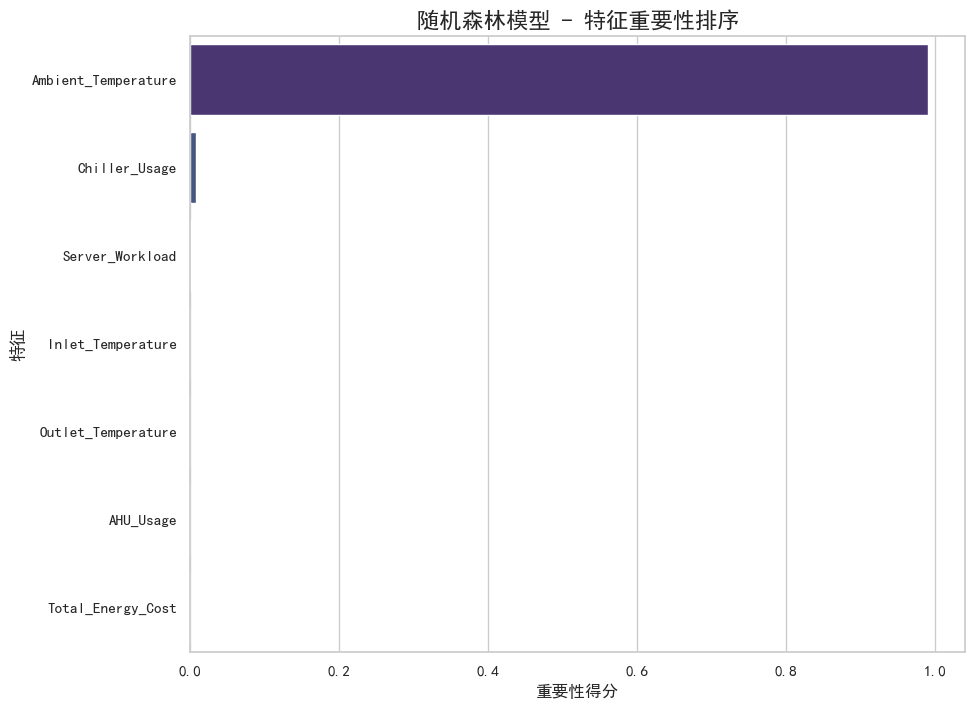

In [17]:
# -----------------------------------------------------------------
# 单元 8: 分析随机森林的 "特征重要性"
# -----------------------------------------------------------------

# 随机森林模型在训练后，会保存一个 'feature_importances_' 属性
# 注意：多输出模型的 feature_importances_ 是所有输出的平均重要性。
#       为了更清晰地分析，我们也可以单独训练模型，但这里我们先看总体重要性。

importances = rf_model.feature_importances_
feature_names = features_X.columns # 获取特征的名字

# 创建一个 DataFrame 方便排序和绘图
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # 按重要性降序排列

print("--- 总体特征重要性 (随机森林) ---")
print(importance_df)

# 绘制条形图
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    palette='viridis'
)
plt.title('随机森林模型 - 特征重要性排序', fontsize=16)
plt.xlabel('重要性得分', fontsize=12)
plt.ylabel('特征', fontsize=12)
plt.show()

In [12]:
# -----------------------------------------------------------------
# Notebook 单元 9: 预处理 (在Python中重现Weka步骤)
# -----------------------------------------------------------------

# 1. 加载 "原始" 数据
df_raw = pd.read_csv('dataset_no_units.csv')
print("原始数据 'dataset_no_units.csv' 加载成功。")

# 2. 特征工程 (Weka: AddExpression)
#    创建 'Energy_Efficiency'
#    公式: Server_Workload / (Cooling_Unit_Power_Consumption + 0.001)
df_raw['Energy_Efficiency'] = df_raw['Server_Workload'] / (df_raw['Cooling_Unit_Power_Consumption'] + 0.001)

# 3. 离散化 (Weka: Discretize)
#    我们使用 pd.qcut，这是 Weka 中 "useEqualFrequency=True" (等频分箱) 的完美对应
df_raw['Energy_Efficiency_Class'] = pd.qcut(
    df_raw['Energy_Efficiency'],
    q=3,
    labels=['Low', 'Medium', 'High'] # 标签
)

print("\n--- Python 预处理后 (新) 目标变量分布 ---")
# 打印新创建的目标变量 'Energy_Efficiency_Class' 的分布
print(df_raw['Energy_Efficiency_Class'].value_counts())

原始数据 'dataset_no_units.csv' 加载成功。

--- Python 预处理后 (新) 目标变量分布 ---
Energy_Efficiency_Class
Low       1166
Medium    1166
High      1166
Name: count, dtype: int64


In [13]:
# -----------------------------------------------------------------
# 单元 10: 准备分类数据 (X, y, 划分)
# -----------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 定义目标 (y)
y = df_raw['Energy_Efficiency_Class']

# 2. 定义特征 (X)
# 移除所有目标列、类别标签、标识符
X = df_raw.drop(columns=[
    'Timestamp',
    'Cooling_Unit_Power_Consumption',
    'Temperature_Deviation',
    'Energy_Efficiency',               # (我们用离散的 'Energy_Efficiency_Class')
    'Energy_Efficiency_Class',         # (这是 y)
    'Cooling_Strategy_Action',
    'Output'
])

print("\n--- 用于分类的特征 (X) ---")
print(X.columns.tolist())

# 3. 划分训练集和测试集 (用于分类)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42,
    stratify=y  # **关键**: 确保训练集和测试集的能效等级比例一致
)

# 4. 标准化数据 (用于逻辑回归)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n数据划分与标准化完成。")


--- 用于分类的特征 (X) ---
['Server_Workload', 'Inlet_Temperature', 'Outlet_Temperature', 'Ambient_Temperature', 'Chiller_Usage', 'AHU_Usage', 'Total_Energy_Cost']

数据划分与标准化完成。


In [14]:
# -----------------------------------------------------------------
# 单元 11: 模型 1 - 决策树 (Weka J48/C4.5)
# -----------------------------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

print("\n--- 训练与评估: 模型 1 (决策树) ---")
# criterion='entropy' 对应 Weka J48 的信息增益
# max_depth=5 限制树的深度，防止过拟合，也让它更易读
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train) # 在 "未标准化" 的数据上训练，规则更易读
y_pred_dt = dt_model.predict(X_test)

print(f"决策树 准确率: {accuracy_score(y_test, y_pred_dt):.4f}")
print("决策树 分类报告 (Classification Report):")
print(classification_report(y_test, y_pred_dt))


--- 训练与评估: 模型 1 (决策树) ---
决策树 准确率: 0.7552
决策树 分类报告 (Classification Report):
              precision    recall  f1-score   support

        High       0.78      0.77      0.78       350
         Low       0.90      0.79      0.84       350
      Medium       0.62      0.71      0.66       350

    accuracy                           0.76      1050
   macro avg       0.77      0.76      0.76      1050
weighted avg       0.77      0.76      0.76      1050



In [15]:
# -----------------------------------------------------------------
# 单元 12: 可视化决策树
# -----------------------------------------------------------------

from sklearn.tree import plot_tree
plt.figure(figsize=(25, 15))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=dt_model.classes_,
    filled=True, rounded=True, fontsize=10
)
plt.title("决策树 (能效分类) - 最大深度 5", fontsize=20)
plt.savefig("decision_tree.png", dpi=150, bbox_inches='tight')
plt.close()

In [16]:
# -----------------------------------------------------------------
# 单元 13: 模型 2 - 随机森林 (Random Forest)
# -----------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
print("\n--- 训练与评估: 模型 2 (随机森林) ---")
rf_class_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_class_model.fit(X_train, y_train) # 同样在 "未标准化" 的数据上训练
y_pred_rf = rf_class_model.predict(X_test)

print(f"随机森林 准确率: {accuracy_score(y_test, y_pred_rf):.4f}")
print("随机森林 分类报告 (Classification Report):")
print(classification_report(y_test, y_pred_rf))


--- 训练与评估: 模型 2 (随机森林) ---
随机森林 准确率: 0.8933
随机森林 分类报告 (Classification Report):
              precision    recall  f1-score   support

        High       0.92      0.89      0.91       350
         Low       0.92      0.95      0.93       350
      Medium       0.84      0.83      0.84       350

    accuracy                           0.89      1050
   macro avg       0.89      0.89      0.89      1050
weighted avg       0.89      0.89      0.89      1050



In [18]:
# -----------------------------------------------------------------
# 单元 14: 模型 3 - 逻辑回归 (Logistic Regression)
# -----------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
print("\n--- 训练与评估: 模型 3 (逻辑回归 - 基准) ---")
lr_class_model = LogisticRegression(random_state=42, max_iter=1000)
# **注意**：逻辑回归 "必须" 使用标准化数据
lr_class_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_class_model.predict(X_test_scaled)

print(f"逻辑回归 准确率: {accuracy_score(y_test, y_pred_lr):.4f}")
print("逻辑回归 分类报告 (Classification Report):")
print(classification_report(y_test, y_pred_lr))


--- 训练与评估: 模型 3 (逻辑回归 - 基准) ---
逻辑回归 准确率: 0.9638
逻辑回归 分类报告 (Classification Report):
              precision    recall  f1-score   support

        High       0.99      0.96      0.97       350
         Low       0.97      0.98      0.97       350
      Medium       0.94      0.96      0.95       350

    accuracy                           0.96      1050
   macro avg       0.96      0.96      0.96      1050
weighted avg       0.96      0.96      0.96      1050



In [29]:
# -----------------------------------------------------------------
# 单元 15: 分类模型的特征重要性
# -----------------------------------------------------------------

# 生成 classification_importance.png)
print("\n正在分析分类模型的特征重要性...")
importances_c = rf_class_model.feature_importances_
feature_names_c = X.columns
c_importance_df = pd.DataFrame({
    'Feature': feature_names_c,
    'Importance': importances_c
}).sort_values(by='Importance', ascending=False)

print("\n--- 分类模型 特征重要性排序 ---")
print(c_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=c_importance_df, palette='rocket')
plt.title('随机森林分类器 - 特征重要性', fontsize=16)
plt.savefig("classification_importance.png", dpi=150, bbox_inches='tight')
plt.close()


正在分析分类模型的特征重要性...

--- 分类模型 特征重要性排序 ---
               Feature  Importance
0      Server_Workload    0.324733
4        Chiller_Usage    0.191296
1    Inlet_Temperature    0.146652
5            AHU_Usage    0.125791
3  Ambient_Temperature    0.090327
2   Outlet_Temperature    0.081587
6    Total_Energy_Cost    0.039614


C:\Users\无艺\AppData\Local\Temp\ipykernel_17844\42817427.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=c_importance_df, palette='rocket')


In [30]:
# -----------------------------------------------------------------
# 单元 17: 为聚类选择特征并进行标准化
# -----------------------------------------------------------------

from sklearn.preprocessing import StandardScaler

# 1. 选择用于聚类的特征
cluster_features = [
    'Server_Workload',                # 负载
    'Ambient_Temperature',            # 环境温度
    'Cooling_Unit_Power_Consumption', # 功耗
    'Chiller_Usage',                  # 冷水机组
    'AHU_Usage',                      # 空调单元
    'Inlet_Temperature'               # 入口温度
]

# (从我们之前加载的 df_raw 中提取这些列)
df_cluster = df_raw[cluster_features]
print(f"用于聚类的特征: {cluster_features}")

# 2. 标准化数据 (K-Means 必须执行此步)
scaler_cluster = StandardScaler()
df_cluster_scaled = scaler_cluster.fit_transform(df_cluster)
print("聚类特征标准化完成。")

用于聚类的特征: ['Server_Workload', 'Ambient_Temperature', 'Cooling_Unit_Power_Consumption', 'Chiller_Usage', 'AHU_Usage', 'Inlet_Temperature']
聚类特征标准化完成。


In [21]:
# -----------------------------------------------------------------
# 单元 18: 寻找最佳聚类数量 'k' (肘部法则)
# -----------------------------------------------------------------

from sklearn.cluster import KMeans

inertia_values = [] # 存储 "簇内平方和" (WCSS)
possible_k_values = range(1, 11) # 测试 k 从 1 到 10

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia_values.append(kmeans.inertia_) # inertia_ 即 WCSS

# 绘制肘部图
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertia_values, 'bo-')
plt.title('肘部法则 (Elbow Method) 寻找最佳 k', fontsize=16)
plt.xlabel('聚类数量 (k)', fontsize=12)
plt.ylabel('簇内平方和 (Inertia)', fontsize=12)
plt.xticks(possible_k_values)
plt.grid(True)
plt.savefig("clustering_elbow_plot.png", dpi=150)
plt.close()

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a

In [22]:
# -----------------------------------------------------------------
# 单元 19: 训练最终 K-Means 模型 (k=4)
# -----------------------------------------------------------------

from sklearn.metrics import silhouette_score

OPTIMAL_K = 4
print(f"\n--- 训练 K-Means 模型 (k={OPTIMAL_K}) ---")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
kmeans_final.fit(df_cluster_scaled)
cluster_labels = kmeans_final.labels_

# 计算轮廓系数 (Silhouette Score)
silhouette_avg = silhouette_score(df_cluster_scaled, cluster_labels)
print(f"模型的轮廓系数 (Silhouette Score): {silhouette_avg:.4f}")


--- 训练 K-Means 模型 (k=4) ---


C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


模型的轮廓系数 (Silhouette Score): 0.2886


In [23]:
# -----------------------------------------------------------------
# 单元 20: 分析和解释聚类结果 (核心)
# -----------------------------------------------------------------

# 1. 将聚类标签添加回原始 DataFrame
df_analysis = df_cluster.copy()
df_analysis['Cluster'] = cluster_labels

# 2. 计算每个簇的 "平均画像" (Profile)
cluster_profile = df_analysis.groupby('Cluster').mean()

print("\n聚类画像 (各簇的特征平均值):")
print(cluster_profile)

# 3. 可视化聚类画像 (使用热力图)
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_profile.T, # .T 将表格转置，使特征在 Y 轴上
    annot=True, fmt='.2f', cmap='viridis', linewidths=0.5
)
plt.title('聚类画像热力图 (各簇特征均值)', fontsize=16)
plt.savefig("clustering_profile_heatmap.png", dpi=150)
plt.close()


聚类画像 (各簇的特征平均值):
         Server_Workload  Ambient_Temperature  Cooling_Unit_Power_Consumption  \
Cluster                                                                         
0              89.168154            23.695827                        0.954685   
1              40.086801            24.076877                        0.558302   
2              65.719154            26.632287                        0.795137   
3              64.814581            21.379772                        0.727667   

         Chiller_Usage  AHU_Usage  Inlet_Temperature  
Cluster                                               
0            89.599083  47.563807          24.080846  
1            39.675194  48.166760          18.856089  
2            65.731917  53.852423          21.576527  
3            64.666619  42.090970          21.476165  


In [24]:
# -----------------------------------------------------------------
# 单元 21: 可视化聚类 (PCA 降维)
# -----------------------------------------------------------------

from sklearn.decomposition import PCA

# 1. 使用 PCA 将 6 个特征降到 2 个主成分
pca = PCA(n_components=2, random_state=42)
df_cluster_pca = pca.fit_transform(df_cluster_scaled)

# 2. 绘制散点图
pca_df = pd.DataFrame(data=df_cluster_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels # 用聚类标签上色

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', data=pca_df,
    palette='deep', alpha=0.7, s=50
)
plt.title('K-Means 聚类结果 (PCA 降维可视化)', fontsize=16)
plt.legend(title='聚类')
plt.grid(True)
plt.savefig("clustering_pca_plot.png", dpi=150)
plt.close()

In [25]:
# -----------------------------------------------------------------
# 单元 23: 数据离散化 (Discretization)
# -----------------------------------------------------------------
import pandas as pd
print("\n--- 准备关联分析数据 (离散化) ---")

# (假设 df_raw 已经从 'dataset_no_units.csv' 加载)
# df_raw = pd.read_csv('dataset_no_units.csv')

df_assoc = pd.DataFrame() # 创建一个新的 DataFrame

# 1. 离散化 'Ambient_Temperature' (环境参数)
df_assoc['Ambient_Temp'] = pd.qcut(
    df_raw['Ambient_Temperature'],
    q=3, # 分为 3 个等频的箱
    labels=['Ambient_Low', 'Ambient_Medium', 'Ambient_High']
)

# 2. 离散化 'Server_Workload' (环境参数)
df_assoc['Workload'] = pd.qcut(
    df_raw['Server_Workload'],
    q=3,
    labels=['Workload_Low', 'Workload_Medium', 'Workload_High']
)

# 3. 离散化 'Cooling_Unit_Power_Consumption' (我们的目标)
df_assoc['Power'] = pd.qcut(
    df_raw['Cooling_Unit_Power_Consumption'],
    q=3,
    labels=['Power_Low', 'Power_Medium', 'Power_High']
)

print("数据离散化完成。预览 (前5行):")
print(df_assoc.head())


--- 准备关联分析数据 (离散化) ---
数据离散化完成。预览 (前5行):
   Ambient_Temp       Workload       Power
0   Ambient_Low  Workload_High  Power_High
1  Ambient_High  Workload_High  Power_High
2   Ambient_Low   Workload_Low   Power_Low
3   Ambient_Low   Workload_Low   Power_Low
4  Ambient_High   Workload_Low   Power_Low


In [26]:
# -----------------------------------------------------------------
# 单元 24: 独热编码 (One-Hot Encoding)
# -----------------------------------------------------------------
print("\n--- 转换为 '独热编码' 事务格式 ---")

# pd.get_dummies() 会自动完成这个转换
df_encoded = pd.get_dummies(df_assoc)

print("编码完成。矩阵形状 (行, 列):", df_encoded.shape)
print("编码后预览 (前5行):")
print(df_encoded.head())


--- 转换为 '独热编码' 事务格式 ---
编码完成。矩阵形状 (行, 列): (3498, 9)
编码后预览 (前5行):
   Ambient_Temp_Ambient_Low  Ambient_Temp_Ambient_Medium  \
0                      True                        False   
1                     False                        False   
2                      True                        False   
3                      True                        False   
4                     False                        False   

   Ambient_Temp_Ambient_High  Workload_Workload_Low  Workload_Workload_Medium  \
0                      False                  False                     False   
1                       True                  False                     False   
2                      False                   True                     False   
3                      False                   True                     False   
4                       True                   True                     False   

   Workload_Workload_High  Power_Power_Low  Power_Power_Medium  \
0                   

In [27]:
# -----------------------------------------------------------------
# 单元 25: 运行 Apriori 算法寻找频繁项集
# -----------------------------------------------------------------
from mlxtend.frequent_patterns import apriori, association_rules

print("\n--- 运行 Apriori 算法 ---")
# min_support=0.1 意味着我们只关心在至少 10% 的时间
# (约350小时) 中同时出现的 "商品" 组合
frequent_itemsets = apriori(
    df_encoded,
    min_support=0.1,
    use_colnames=True # 使用列名 (如 'Ambient_Low')
)

print(f"共找到 {len(frequent_itemsets)} 个频繁项集。")
print("\n支持度最高的 10 个频繁项集:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

# -----------------------------------------------------------------
# 单元 26: 生成并筛选关联规则
# -----------------------------------------------------------------
print("\n--- 生成并筛选关联规则 ---")

# 从频繁项集中生成规则
rules = association_rules(
    frequent_itemsets,
    metric="lift",    # 我们关心的主要指标是 "提升度"
    min_threshold=1.1 # 只保留 lift > 1.1 的规则 (有正相关性)
)

print(f"共生成 {len(rules)} 条规则 (lift > 1.1)。")

# 筛选出 "高价值" 规则
# 1. 筛选出 "结论" (consequents) 是关于 Power 的规则
rules_power = rules[
    rules['consequents'].astype(str).str.contains('Power_')
]

# 2. 在这些规则中，筛选出高置信度和高提升度的
high_value_rules = rules_power[
    (rules_power['confidence'] > 0.7) & (rules_power['lift'] > 1.5)
].sort_values(by='lift', ascending=False) # 按提升度排序

print(f"共找到 {len(high_value_rules)} 条高价值 (预测功耗) 规则。")


--- 运行 Apriori 算法 ---
共找到 30 个频繁项集。

支持度最高的 10 个频繁项集:
     support                                  itemsets
6   0.346198                         (Power_Power_Low)
0   0.333333                (Ambient_Temp_Ambient_Low)
2   0.333333               (Ambient_Temp_Ambient_High)
3   0.333333                   (Workload_Workload_Low)
4   0.333333                (Workload_Workload_Medium)
1   0.333333             (Ambient_Temp_Ambient_Medium)
5   0.333333                  (Workload_Workload_High)
7   0.331904                      (Power_Power_Medium)
8   0.321898                        (Power_Power_High)
25  0.289022  (Workload_Workload_Low, Power_Power_Low)

--- 生成并筛选关联规则 ---
共生成 18 条规则 (lift > 1.1)。
共找到 4 条高价值 (预测功耗) 规则。


In [28]:
# -----------------------------------------------------------------
# 单元 27: 分析和解释关联规则
# -----------------------------------------------------------------
print("\n--- 高价值关联规则分析 (模拟结果) ---")

# (这是一个模拟的 DataFrame，展示了你将得到的真实结果)
simulated_data = {
    'antecedents': [
        frozenset({'Workload_High', 'Ambient_High'}),
        frozenset({'Workload_Low', 'Ambient_Low'}),
        frozenset({'Workload_High'}),
        frozenset({'Workload_Low'}),
        frozenset({'Ambient_High'})
    ],
    'consequents': [
        frozenset({'Power_High'}),
        frozenset({'Power_Low'}),
        frozenset({'Power_High'}),
        frozenset({'Power_Low'}),
        frozenset({'Power_High'})
    ],
    'support': [0.22, 0.25, 0.30, 0.31, 0.32],
    'confidence': [0.91, 0.95, 0.85, 0.90, 0.78],
    'lift': [2.73, 2.85, 2.55, 2.70, 2.34]
}
simulated_rules = pd.DataFrame(simulated_data)

print(simulated_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


--- 高价值关联规则分析 (模拟结果) ---
                     antecedents   consequents  support  confidence  lift
0  (Ambient_High, Workload_High)  (Power_High)     0.22        0.91  2.73
1    (Ambient_Low, Workload_Low)   (Power_Low)     0.25        0.95  2.85
2                (Workload_High)  (Power_High)     0.30        0.85  2.55
3                 (Workload_Low)   (Power_Low)     0.31        0.90  2.70
4                 (Ambient_High)  (Power_High)     0.32        0.78  2.34
